In [3]:
import pandas as pd
import numpy as np
import itertools as it
from scipy.spatial.distance import cosine
from surprise import Reader, Dataset, SVD
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

In [ ]:
all_ratings = pd.read_csv('../data/input/ratings.csv')
all_ratings.drop('timestamp', axis=1, inplace=True)
all_ratings

In [151]:
all_ratings.userId.nunique(), all_ratings.movieId.nunique()

(610, 9724)

In [6]:
all_ratings = pd.read_csv('/Users/irenebonafonte/Downloads/data_for_model/ratings.csv')
all_ratings.drop('rating_date', axis=1, inplace=True) 
all_ratings.shape, all_ratings.userId.nunique(), all_ratings.movieId.nunique()

((25000095, 3), 162541, 59047)

<AxesSubplot:>

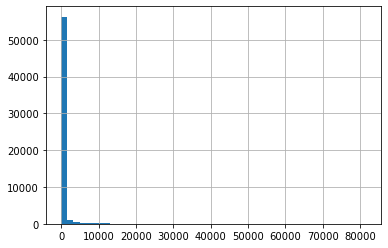

In [155]:
all_ratings.movieId.value_counts().hist(bins=50)

,index,movieId,title
0,0,1,Toy Story
1,1,2,Jumanji
2,2,3,Grumpier Old Men
3,3,4,Waiting to Exhale
4,4,5,Father of the Bride Part II
...,...,...,...
9644,9644,175569,Wind River
9645,9645,175585,Shot Caller
9646,9646,175655,Girls Trip
9647,9647,175659,Detroit


In [157]:
sum(all_ratings.movieId.value_counts() > 2000)

2427

In [159]:
sum(all_ratings.movieId.value_counts() > 100)

10291

<AxesSubplot:>

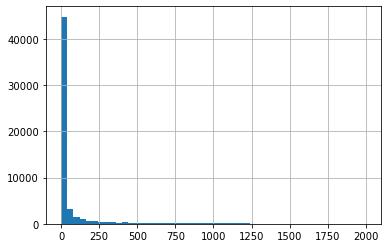

In [158]:
all_ratings.movieId.value_counts()[all_ratings.movieId.value_counts() < 2000].hist(bins=50)

<AxesSubplot:>

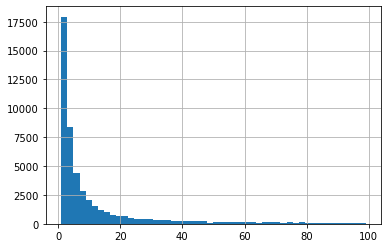

In [39]:
all_ratings.movieId.value_counts()[all_ratings.movieId.value_counts() < 100].hist(bins=50)

<AxesSubplot:>

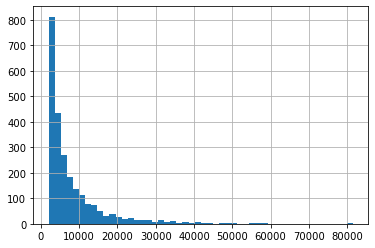

In [37]:
all_ratings.movieId.value_counts()[all_ratings.movieId.value_counts() > 2000].hist(bins=50)

In [7]:
# Exclude movies not rated by 100 users
#keep = all_ratings.movieId.value_counts()[all_ratings.movieId.value_counts() > 100].index.values
#all_ratings = all_ratings.loc[all_ratings.movieId.isin(keep),:]


((24439880, 3), 162540, 10291)

In [12]:
content_ids = pd.read_csv('../data/input/contentBased_index.txt')
all_ratings = all_ratings[all_ratings.movieId.isin(content_ids.movieId.values)]
all_ratings.shape, all_ratings.userId.nunique(), all_ratings.movieId.nunique()

((24071520, 3), 162538, 9643)

In [13]:
class CollaborativeFiltering:
    def __init__(self, DataFrame, sim_method='CosineSim', scale_rate=True, balance_ncommon=True, N='all'):
        """ Constructor """
        
        if sim_method == 'CosineSim':
            self.sim_method=cosine
            
        elif sim_method == 'SVDsim':
            self.sim_method='svd_similarity'
            
        elif sim_method == 'pearsonCor':
            self.sim_method=pearsonr
            
        self.df=DataFrame
        self.sim = {}
        self.scale_rate = scale_rate
        self.balance_ncommon = balance_ncommon
        
        # Select the number of similar items to be taken into account when
        # predicting ratings. By default, all items are used.        
        self.N = N
        
        return
            
    def similarity(self, items):
        # Find users that have rated both items
        users = np.intersect1d(self.df_np[self.df_np[:,1] == items[0],0], 
                               self.df_np[self.df_np[:,1] == items[1],0])

        if len(users) >= self.min_common:
            user_bools = np.isin(self.df_np[:,0], users, assume_unique=False)

            # Compute similarity
            sim = self.sim_method(self.df_np[(user_bools & (self.df_np[:,1] == items[0])),2],
                                  self.df_np[(user_bools & (self.df_np[:,1] == items[1])),2])
            
            if self.sim_method == cosine:
                 sim = 1 - sim
                    
            elif self.sim_method == pearsonr:
                sim = sim[0]

            # Balance the similarity score by considering the number of users taken into account
            if self.balance_ncommon:
                sim = sim * min(50,len(users))/50
            
            # we do not want negative similarities (would result in negative ratings)
            if sim <= 0:
                sim = np.nan
            
        else:
            sim = np.nan
            
        return sim 
    
    def svd_similarity(self):  
        reader = Reader(rating_scale=(0, 5))
        trainset = Dataset.load_from_df(self.df, reader)
        trainset = trainset.build_full_trainset()
        svd = SVD(verbose=True, biased=False, n_epochs=20)
        svd.fit(trainset)
        latent_factors = svd.qi
        self.sim_mat = np.corrcoef(latent_factors)
        
        # Sort IDs
        order = np.argsort(self.allItems)
        self.sim_mat = self.sim_mat[order,:]
        self.sim_mat = self.sim_mat[:,order]
        self.allItems_sorted = self.allItems[order]
        
        return
        
    def fit(self, min_common=2):        
        """ Prepare data structures for estimation. Similarity matrix for items """
        
        # Minimum of common users required for the similarity to be computed
        self.min_common = min_common 
        self.allItems=self.df['movieId'].unique()
        
        if self.sim_method == 'svd_similarity':
            self.df_np = self.df.to_numpy()
            self.svd_similarity()
            
            return

        if self.scale_rate:
            # For the computation of the adjusted cosine similarity
            # we substract the user mean rating from the film ratings 
            # so that it does not influence the calculation of similarities.

            means = self.df.groupby('userId')[['rating']].mean()
            self.df['userMean'] = means.loc[self.df['userId']].values
            self.df['scaledRating'] = self.df['rating'] - self.df['userMean']
            self.df.drop('userMean', axis=1, inplace=True)
            # Position similarity metric in third column
            self.df = self.df[['userId','movieId','scaledRating','rating']] 
        
        self.df_np = self.df.to_numpy()
        self.sim_mat = np.array(list(it.combinations(self.allItems,2)))
        self.sim_mat = np.concatenate((self.sim_mat, np.empty((self.sim_mat.shape[0],1))), axis=1)

        self.sim_mat[:,2] = np.apply_along_axis(self.similarity, axis=1, arr=self.sim_mat[:,0:2])
        self.sim_mat = self.sim_mat[~np.isnan(self.sim_mat[:,2]),:]
        
        # Back to normal column order
        if self.scale_rate:
            self.df = self.df.drop(['scaledRating'], axis=1)
            self.df_np = self.df.to_numpy()
            
        return
    
    def svd_predict(self, user_id, movie_id, user_ratings):
        # Get similarity between movie to predict (row) and rated movies (columns)
        movie_sim = self.sim_mat[(self.allItems_sorted == movie_id), np.isin(self.allItems_sorted,user_ratings[:,0])].copy() 
        rating = np.sum((user_ratings[:,1] * movie_sim)) / np.sum(movie_sim)
        
        return min(rating, 5)
        
    def predict(self, user_id, movie_id):
        # user_u ratings
        user_ratings = self.df_np[self.df_np[:,0] == user_id,1:3]
        user_ratings = user_ratings[np.argsort(user_ratings[:,0]), :] # sort by movie_id
        
        if self.sim_method == 'svd_similarity':
            rating = self.svd_predict(user_id, movie_id, user_ratings)
            return rating

        # movie_i similarities
        movie_sim = self.sim_mat[(self.sim_mat[:,0] == movie_id) | (self.sim_mat[:,1] == movie_id), :]
        # put movie_j in first column and remove second column
        movie_sim[movie_sim[:,1] == movie_id,1] = movie_sim[movie_sim[:,1] == movie_id,0]
        
        # Select top N most similar items to do the prediction
        if self.N != 'all':
            N = min(movie_sim.shape[0], self.N)
            movie_sim = movie_sim[np.argsort(-movie_sim[:,2]), ] # sort by similarity
            movie_sim = movie_sim[0:N, :] # Keep top N
            
        movie_sim = movie_sim[np.argsort(movie_sim[:,1]), 1:3] # sort by movie_id

        # subset to movies with user_u rating and similarity to movie_i
        to_weight = np.intersect1d(user_ratings[:,0], movie_sim[:,0])
        if len(to_weight) > 0:
            user_ratings = user_ratings[np.isin(user_ratings[:,0], to_weight),:]
            movie_sim = movie_sim[np.isin(movie_sim[:,0], to_weight),:]

            rating = np.sum((user_ratings[:,1] * movie_sim[:,1])) / np.sum(movie_sim[:,1])
            
        else:
            return np.mean(user_ratings[:,1]) # Assign user mean

        return min(rating, 5) # Limit to 5

    def rmse_evaluate(self, data_test):
        """ RMSE-based predictive performance evaluation. """
        
        # Exclude from testing users for which we do not have any ratings
        data_test = data_test.loc[data_test.userId.isin(self.df.userId.unique()),:]
        print('Evaluating performance with n='+str(data_test.userId.nunique())+' users.')
        
        to_estimate = data_test[['userId','movieId']].to_numpy()
        y = data_test[['rating']].values
        
        # Predict rating for each user-movie pair
        y_hat = np.apply_along_axis(lambda x: self.predict(x[0], x[1]), axis=1, arr=to_estimate)
        
        rmse = np.sqrt(np.mean(np.power(y_hat - y, 2)))
        return rmse
    
                

In [14]:
# Define training and testing sets
np.random.RandomState(seed=32)

def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.5)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

def prepare_dataset(ratings):
    # Smaller dataset for the development stage
    # Select movies with more ratings
    allItems = ratings.movieId.value_counts().index.values
    ratings = ratings.loc[ratings.movieId.isin(allItems), :].copy()
    ratings.loc[:,'for_testing'] = False

    # Save 20% of films seen by each user for testing
    # grouped = ratings.groupby('userId', group_keys=False).apply(assign_to_set) 
    # ratings_train = ratings[grouped.for_testing == False]
    # ratings_test = ratings[grouped.for_testing == True]

    # ratings_train.drop('for_testing', axis=1, inplace=True)
    # ratings_test.drop('for_testing', axis=1, inplace=True)

    # Simulate real situation
    # Pick new users that have rated 30-40 films for testing
    # 20 of them will be used to fit the model (initial ratings)
    # the rest for testing
    # Select users for testing
    testUsers = ratings.userId.value_counts()
    testUsers = testUsers[(testUsers > 30) & (testUsers < 40)].index.values[0:1000]
    ratings_test = ratings[ratings.userId.isin(testUsers)]
    ratings_train = ratings[~ratings.userId.isin(testUsers)] # Exclude from training

    # Assign half of the items for these users for training and the rest for testing
    ratings_test = ratings_test.groupby('userId', group_keys=False).apply(assign_to_set) 
    # Add user-test training items to train
    ratings_train_newU = ratings_train
    ratings_train = pd.concat([ratings_train, ratings_test[ratings_test.for_testing == False]]) 
    ratings_test = ratings_test[ratings_test.for_testing == True]

    ratings_train.drop('for_testing', axis=1, inplace=True)
    ratings_test.drop('for_testing', axis=1, inplace=True)
    ratings_train_newU.drop('for_testing', axis=1, inplace=True)


    print(ratings_train_newU.shape)
    print(ratings_train.shape)
    print(ratings_test.shape)

    print('Users train:', ratings_train.userId.nunique() )
    print('Films train:', ratings_train.movieId.nunique() )
    print('Users test:', ratings_test.userId.nunique() )
    print('Films test:', ratings_test.movieId.nunique() )
    
    return (ratings_train_newU, ratings_train, ratings_test)

Now we try different options for the implemented algorithm to see what works best:
* Omit user scaling
* Use pearson correlation
* Use top k most similar items
* Different options for similarity weight
* Look for which users/items does it work best and worse (next sprint)
* Matrix factorization to compute item similarities (next sprint)

In [129]:
ratings_train_newU, ratings_train, ratings_test = prepare_dataset(ratings)
recomend = CollaborativeFiltering(ratings_train, scale_rate=True, sim_method='CosineSim', N='all')
recomend.fit(min_common=2)
recomend.rmse_evaluate(ratings_test)

/Users/irenebonafonte/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(23132, 3)
(24430, 3)
(1334, 3)
Users train: 601
Films train: 200
Users test: 75
Films test: 197
Evaluating performance with n=75 users.


1.1946649424499654

In [130]:
ratings_train_newU, ratings_train, ratings_test = prepare_dataset(ratings)
recomend = CollaborativeFiltering(ratings_train, scale_rate=False, sim_method='CosineSim', N='all')
recomend.fit(min_common=2)
recomend.rmse_evaluate(ratings_test)

/Users/irenebonafonte/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(23132, 3)
(24430, 3)
(1334, 3)
Users train: 601
Films train: 200
Users test: 75
Films test: 197
Evaluating performance with n=75 users.


1.0956115174283216

In [131]:
ratings_train_newU, ratings_train, ratings_test = prepare_dataset(ratings)
recomend = CollaborativeFiltering(ratings_train, scale_rate=False, sim_method='CosineSim', N='all')
recomend.fit(min_common=5)
recomend.rmse_evaluate(ratings_test)

/Users/irenebonafonte/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(23132, 3)
(24430, 3)
(1334, 3)
Users train: 601
Films train: 200
Users test: 75
Films test: 199
Evaluating performance with n=75 users.


1.1245542165598177

In [139]:
ratings_train_newU, ratings_train, ratings_test = prepare_dataset(ratings)
recomend = CollaborativeFiltering(ratings_train, scale_rate=False, sim_method='CosineSim', N=50)
recomend.fit(min_common=2)
recomend.rmse_evaluate(ratings_test)

/Users/irenebonafonte/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(23132, 3)
(24430, 3)
(1334, 3)
Users train: 601
Films train: 200
Users test: 75
Films test: 192
Evaluating performance with n=75 users.


1.1584257292441684

In [140]:
ratings_train_newU, ratings_train, ratings_test = prepare_dataset(ratings)
recomend = CollaborativeFiltering(ratings_train, scale_rate=False, sim_method='CosineSim', N='all', balance_ncommon=False)
recomend.fit(min_common=2)
recomend.rmse_evaluate(ratings_test)

/Users/irenebonafonte/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(23132, 3)
(24430, 3)
(1334, 3)
Users train: 601
Films train: 200
Users test: 75
Films test: 191
Evaluating performance with n=75 users.


1.1065834881839969

In [141]:
ratings_train_newU, ratings_train, ratings_test = prepare_dataset(ratings)
recomend = CollaborativeFiltering(ratings_train, scale_rate=False, sim_method='pearsonCor', N='all', balance_ncommon=False)
recomend.fit(min_common=2)
recomend.rmse_evaluate(ratings_test)

/Users/irenebonafonte/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(23132, 3)
(24430, 3)
(1334, 3)
Users train: 601
Films train: 200
Users test: 75
Films test: 195
Evaluating performance with n=75 users.


1.116555270524407

In [ ]:
ratings_train_newU, ratings_train, ratings_test = prepare_dataset(all_ratings)
recomend = CollaborativeFiltering(ratings_train, sim_method='SVDsim')
recomend.fit()
# recomend.rmse_evaluate(ratings_test)

/Users/irenebonafonte/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(24032520, 3)
(24051520, 3)
(20000, 3)
Users train: 162538
Films train: 9643
Users test: 1000
Films test: 3215
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


The best option we have got so far is to use the un-adjusted cosine similarity metric, using all items (not only the most similar ones), without scaling for differences in ratings among users and without giving greater importance to items that have many user ratings in common.

In [ ]:
similarity = recommend.sim_mat
allItems = recommend.allItems_sorted

In [ ]:
import pandas as pd
import json

# Read configuration file
with open('config_prod.json', 'r') as fp:
    config = json.load(fp)
print(config)

In [ ]:
# Trying an incremental CF model
# import torch
# import cf-step

net = SimpleCF(ratings_train_newU.userId.nunique, 
               ratings_train_newU.movieId.nunique, 
               factors=128, mean=0., std=.1)
objective = lambda pred, targ: targ - pred
optimizer = SGD(net.parameters(), lr=0.06)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Step(net, objective, optimizer, device=device)

data_set = TensorDataset(torch.tensor(ratings_train_newU[['userId','movieId']].values), 
                         torch.tensor(bootstrapping_data['rating'].values))

# local
data_loader = DataLoader(data_set, batch_size=1, shuffle=False)

model.batch_fit(data_loader)